# COVID DETECTION USING CHEST X-RAY SCANS
## Submitted by - 
### 1) Utkarsh Bhardwaj
###   2K18/CO/379
### 2) Vishesh dargan
###   2K18/CO/389

#Integrating kaggle with google colab to download the dataset directly into colab.

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [ ]:
!unzip covid19-radiography-database.zip

#Importing all the necessary libraries.

In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.callbacks import EarlyStopping

%matplotlib inline

#Declaring the hyper parameters

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']
batch_size_val = 64  # how many to process together
steps_per_epoch_val = 20
epochs_val = 1000
imageDimesions = (180, 180, 1)
target_size_val = (180, 180)
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
noOfClasses = 3
stride_value = 2

# Python script for arranging the dataset into a structure fit for Image data generators while also dividing the data into training and test set.

In [ ]:
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

if not os.path.isdir(os.path.join(root_dir, 'train')):
    os.mkdir(os.path.join(root_dir, 'train'))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'train', c))
        
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        for image in images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'train', c, image)
            shutil.move(source_path, target_path)
    for c in class_names:
        os.rmdir(os.path.join(root_dir, c))

# Declaring the model architecture as a function making it easier to call a build model function and get a compiled model to use.

In [ ]:
def myModel():
    no_Of_Filters = 64
    
    no_Of_Filters2 = 30
    
    size_of_Filter = (3, 3)
    size_of_Filter2 = (3,3)
    size_of_pool = (2,2)
    no_Of_Nodes = 64
    model= Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape = imageDimesions, activation='relu')))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size = size_of_pool, strides=stride_value)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
    model.add(Dropout(0.2))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool, strides=stride_value))
    model.add(Dropout(0.2))

    model.add(Flatten())
    # model.add(Dropout(0.3))
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


model = myModel()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 178, 178, 64)      640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 176, 176, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 88, 88, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 88, 88, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 86, 86, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 84, 84, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 64)       

# Normalisation of images

In [ ]:
def preprocessing(img):
    img = img/255                                   # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

# Making the Image Data Generators for data augmentation.

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10,
                            horizontal_flip = True,
                            validation_split = validationRatio,
                            preprocessing_function = preprocessing)

# Using flow_from_directory to import data into the generator

In [ ]:
train_generator = datagen.flow_from_directory(os.path.join(root_dir, 'train'),
                                              subset = 'training',
                                              color_mode = "grayscale",
                                              target_size = target_size_val,
                                              batch_size = batch_size_val)

Found 2253 images belonging to 3 classes.


# Since we're using grayscale images for calculations, the image shape in the data generator has 1 channel as we set the color_mode above to grayscale.

In [ ]:
print(train_generator.image_shape)

(180, 180, 1)


# Printing the label map for future references.

In [ ]:
label_map = (train_generator.class_indices)
print(label_map)

{'covid': 0, 'normal': 1, 'viral': 2}


# The validation generator consists of the data used for validation and comprises of 20% of the training data.

In [ ]:
val_generator = datagen.flow_from_directory(os.path.join(root_dir, 'train'),
                                            subset = 'validation',
                                            color_mode = "grayscale",
                                            target_size=target_size_val,
                                            batch_size=batch_size_val)

Found 562 images belonging to 3 classes.


# Initialising the callbacks (Early Stopping here) and appending them to the callbacks list.
## It is note worthy that restore best weights has been set to true which would restore the weights of the epoch which had the best value for the quantity beinng monitored, validation accuracy in this case.

In [ ]:
cb = EarlyStopping(monitor="val_accuracy",
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = True,
)

cb_list = [cb]

# Fitting the model with number of epochs set to 1000

In [ ]:
history = model.fit_generator(train_generator,
                            epochs=epochs_val,
                            validation_data=val_generator,
                            shuffle=1,
                            callbacks = cb_list)

Epoch 1/1000
36/36 [==============================] - 645s 18s/step - loss: 0.9840 - accuracy: 0.4572 - val_loss: 0.8701 - val_accuracy: 0.4698
Epoch 2/1000
36/36 [==============================] - 642s 18s/step - loss: 0.8198 - accuracy: 0.5513 - val_loss: 0.7935 - val_accuracy: 0.6281
Epoch 3/1000
36/36 [==============================] - 645s 18s/step - loss: 0.7115 - accuracy: 0.6485 - val_loss: 0.5092 - val_accuracy: 0.8060
Epoch 4/1000
36/36 [==============================] - 641s 18s/step - loss: 0.6065 - accuracy: 0.7483 - val_loss: 0.4665 - val_accuracy: 0.8274
Epoch 5/1000
36/36 [==============================] - 641s 18s/step - loss: 0.5644 - accuracy: 0.7679 - val_loss: 0.5110 - val_accuracy: 0.7687
Epoch 6/1000
36/36 [==============================] - 643s 18s/step - loss: 0.5125 - accuracy: 0.7865 - val_loss: 0.4182 - val_accuracy: 0.8523
Epoch 7/1000
36/36 [==============================] - 643s 18s/step - loss: 0.4973 - accuracy: 0.8047 - val_loss: 0.4426 - val_accuracy:

# Saving the model for future use as it took 6.5 hrs to train.

In [ ]:
model.save('itis91.h5')

Also saving the model architecture in a json format and the associated weights in another H5 file as this is the preferred format for deploying the model on the web.

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("weights91.h5")

# Uncomment to load the model for direct use.

In [ ]:
# model = load_model('itis91.h5')

# Visualisation
## Plotting the accuracy and loss curves for training and validation with respect to epochs.

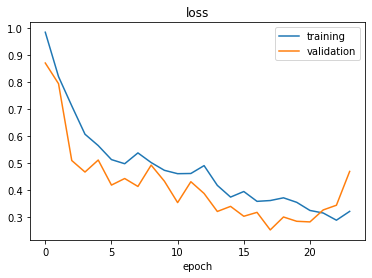

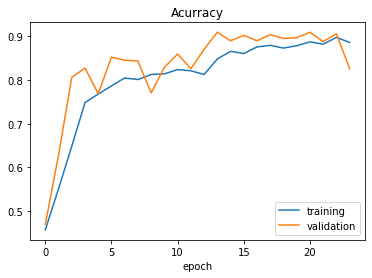

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

# Declaring the paths to the directories of the training set.

In [ ]:
pathnormal = os.path.join(root_dir, 'test', 'normal')
pathcovid = os.path.join(root_dir, 'test', 'covid')
pathviral = os.path.join(root_dir, 'test', 'viral')

## 1) Loading the test data
## 2) Preprocessing the test data
## 3) Making predictions on the data
## 4) Appending the predicted labels to one list and the true labels to another.
## 5) Making the classification report and the confusion matrix for the predictions.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[24  2  4]
 [ 1 28  1]
 [ 0  4 26]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.82      0.93      0.87        30
           2       0.84      0.87      0.85        30

    accuracy                           0.87        90
   macro avg       0.87      0.87      0.87        90
weighted avg       0.87      0.87      0.87        90



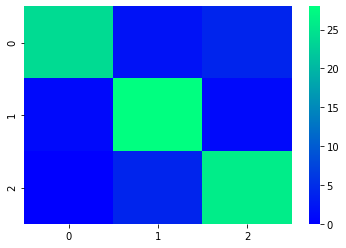

In [ ]:
images = []
truevals = []
pred = []

mylist = os.listdir(pathnormal)
for y in mylist:
  img = cv2.imread(os.path.join(pathnormal, y))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (180, 180))
  img = np.expand_dims(img, axis = 0)
  img = np.expand_dims(img, axis = 3)
  img = img/255.0
  images.append(img)
  truevals.append(1)

mylist = os.listdir(pathcovid)

for y in mylist:
  #plt.imshow(os.path.join(pathcovid, y))
  break

for y in mylist:
  img = cv2.imread(os.path.join(pathcovid, y))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (180, 180))
  img = np.expand_dims(img, axis = 0)
  img = np.expand_dims(img, axis = 3)
  img = img/255.0
  images.append(img)
  truevals.append(0)

mylist = os.listdir(pathviral)
for y in mylist:
  img = cv2.imread(os.path.join(pathviral, y))
  # print(img.shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (180, 180))
  img = np.expand_dims(img, axis = 0)
  img = np.expand_dims(img, axis = 3)
  # print(img.shape)
  # plt.imshow(img)
  img = img/255.0
  images.append(img)
  truevals.append(2)

for y in images:
  pred.append(model.predict_classes(y))

mat = confusion_matrix(truevals, pred)
print(mat)

clfrpt = classification_report(truevals, pred)
print(clfrpt)

sns.heatmap(mat, cmap='winter')

#Importing the necessary libraries to calculate AUC scores.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Calculating the AUC score

In [ ]:
truevals0 = []
pred0 = []

for i in range(len(truevals)):
  if truevals[i] == 0:
    truevals0.append(truevals[i])
    pred0.append(pred[i])
  else:
    truevals0.append(1)
    if pred[i]==0:
      pred0.append(0)
    else:
      pred0.append(1)

In [ ]:
roc_auc_score(truevals0, pred0)

0.8261111111111112

# Plotting the ROC curve with the calculated AUC score on it.

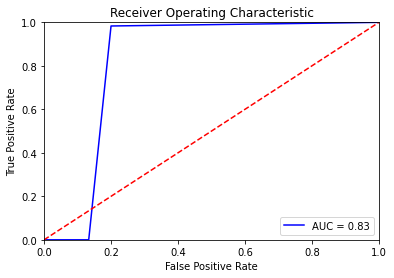

In [ ]:
fpr, tpr, threshold = roc_curve(truevals0, pred0)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Performing similar predictive analysis on the training data as above.

In [ ]:
pathnormal = os.path.join(root_dir, 'train', 'normal')
pathcovid = os.path.join(root_dir, 'train', 'covid')
pathviral = os.path.join(root_dir, 'train', 'viral')
images = []
truevals = []
pred = []

mylist = os.listdir(pathnormal)
for y in mylist:
  img = cv2.imread(os.path.join(pathnormal, y))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (180, 180))
  img = np.expand_dims(img, axis = 0)
  img = np.expand_dims(img, axis = 3)
  img = img/255.0
  images.append(img)
  truevals.append(1)

mylist = os.listdir(pathcovid)

for y in mylist:
  #plt.imshow(os.path.join(pathcovid, y))
  break

for y in mylist:
  img = cv2.imread(os.path.join(pathcovid, y))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (180, 180))
  img = np.expand_dims(img, axis = 0)
  img = np.expand_dims(img, axis = 3)
  img = img/255.0
  images.append(img)
  truevals.append(0)

mylist = os.listdir(pathviral)
for y in mylist:
  img = cv2.imread(os.path.join(pathviral, y))
  # print(img.shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (180, 180))
  img = np.expand_dims(img, axis = 0)
  img = np.expand_dims(img, axis = 3)
  # print(img.shape)
  # plt.imshow(img)
  img = img/255.0
  images.append(img)
  truevals.append(2)

for y in images:
  pred.append(model.predict_classes(y))

mat = confusion_matrix(truevals, pred)
print(mat)

clfrpt = classification_report(truevals, pred)
print(clfrpt)

[[ 145   16   28]
 [   8 1271   32]
 [  12  187 1116]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       189
           1       0.86      0.97      0.91      1311
           2       0.95      0.85      0.90      1315

    accuracy                           0.90      2815
   macro avg       0.90      0.86      0.88      2815
weighted avg       0.90      0.90      0.90      2815



# AUC ROC score for the entire data

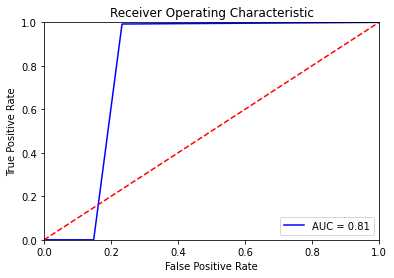

In [ ]:
truevals0 = []
pred0 = []

for i in range(len(truevals)):
  if truevals[i] == 0:
    truevals0.append(truevals[i])
    pred0.append(pred[i])
  else:
    truevals0.append(1)
    if pred[i]==0:
      pred0.append(0)
    else:
      pred0.append(1)
      fpr, tpr, threshold = roc_curve(truevals0, pred0)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()